In [73]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [74]:
# Load the dataset
data = pd.read_csv('/content/customer_support_tickets.csv')

In [75]:
data.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [76]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [77]:
data.describe()


,Ticket ID,Customer Age,Customer Satisfaction Rating
count,8469.000000,8469.000000,2769.000000
mean,4235.000000,44.026804,2.991333
std,2444.934048,15.296112,1.407016
min,1.000000,18.000000,1.000000
25%,2118.000000,31.000000,2.000000
50%,4235.000000,44.000000,3.000000
75%,6352.000000,57.000000,4.000000
max,8469.000000,70.000000,5.000000


In [78]:
# Drop unnecessary identifier columns
data.drop(['Ticket ID', 'Customer Name', 'Customer Email'], axis=1, inplace=True)

# Convert date columns
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')
data['First Response Time'] = pd.to_datetime(data['First Response Time'], errors='coerce')
data['Time to Resolution'] = pd.to_datetime(data['Time to Resolution'], errors='coerce')


In [79]:
# Create resolution time in hours
data['Resolution_Time_Hours'] = (
    data['Time to Resolution'] - data['First Response Time']
).dt.total_seconds() / 3600

# Drop original time columns
data.drop(['First Response Time', 'Time to Resolution'], axis=1, inplace=True)


In [80]:
# Remove rows without satisfaction rating
data = data.dropna(subset=['Customer Satisfaction Rating'])

# Convert satisfaction into categories
def satisfaction_level(score):
    if score <= 2:
        return 'Low'
    elif score == 3:
        return 'Medium'
    else:
        return 'High'

data['Satisfaction_Level'] = data['Customer Satisfaction Rating'].apply(satisfaction_level)


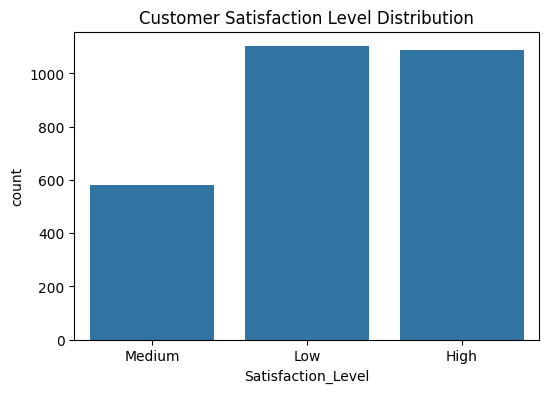

In [81]:
# Exploratory Analysis
plt.figure(figsize=(6,4))
sns.countplot(x='Satisfaction_Level', data=data)
plt.title('Customer Satisfaction Level Distribution')
plt.show()


In [82]:
# Encoding Categorical variables
label_encoders = {}

for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [83]:
# Train-Test Split
X = data.drop(['Customer Satisfaction Rating', 'Satisfaction_Level'], axis=1)
y = data['Satisfaction_Level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [84]:
# Feature Scaling
# Convert 'Date of Purchase' to numerical (Unix timestamp) before scaling
X_train['Date of Purchase'] = X_train['Date of Purchase'].apply(lambda x: x.timestamp() if pd.notna(x) else x)
X_test['Date of Purchase'] = X_test['Date of Purchase'].apply(lambda x: x.timestamp() if pd.notna(x) else x)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
# Model 1 - Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))


Logistic Regression Accuracy: 0.4055354993983153
              precision    recall  f1-score   support

           0       0.39      0.48      0.43       326
           1       0.42      0.55      0.47       331
           2       0.00      0.00      0.00       174

    accuracy                           0.41       831
   macro avg       0.27      0.34      0.30       831
weighted avg       0.32      0.41      0.36       831



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [86]:
# Model 2 - Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.40794223826714804
              precision    recall  f1-score   support

           0       0.42      0.49      0.45       326
           1       0.40      0.53      0.46       331
           2       0.20      0.01      0.01       174

    accuracy                           0.41       831
   macro avg       0.34      0.34      0.31       831
weighted avg       0.37      0.41      0.36       831



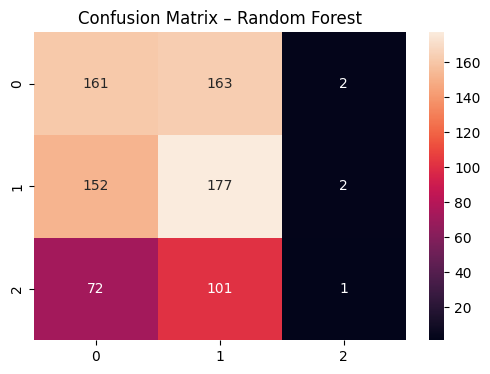

In [87]:
# Comfusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d')
plt.title("Confusion Matrix – Random Forest")
plt.show()


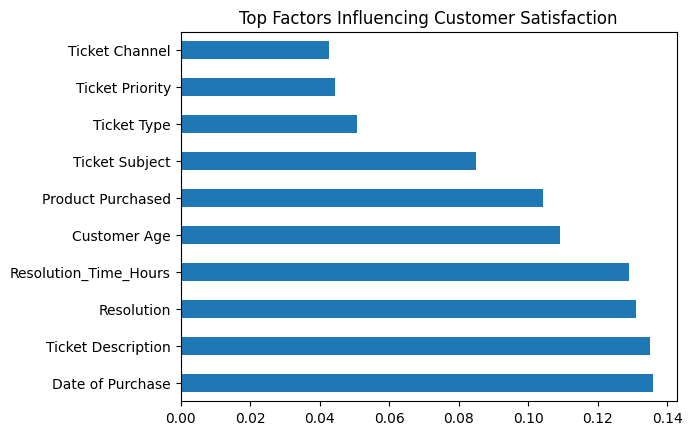

In [88]:
# Feature Importance
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top Factors Influencing Customer Satisfaction")
plt.show()


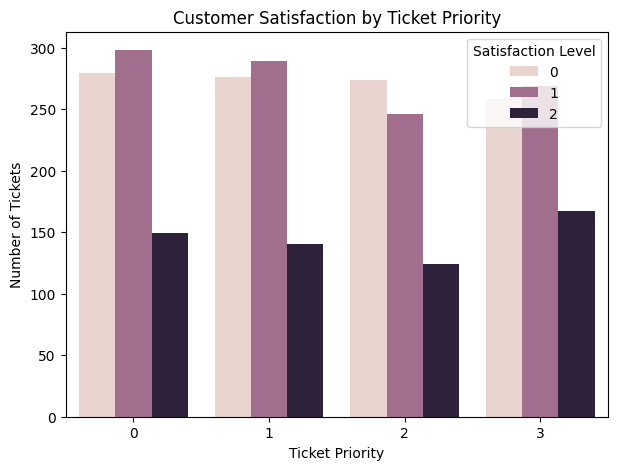

In [89]:
# Satisfaction Level by Ticket Priority
plt.figure(figsize=(7,5))
sns.countplot(
    x='Ticket Priority',
    hue='Satisfaction_Level',
    data=data
)
plt.title('Customer Satisfaction by Ticket Priority')
plt.xlabel('Ticket Priority')
plt.ylabel('Number of Tickets')
plt.legend(title='Satisfaction Level')
plt.show()


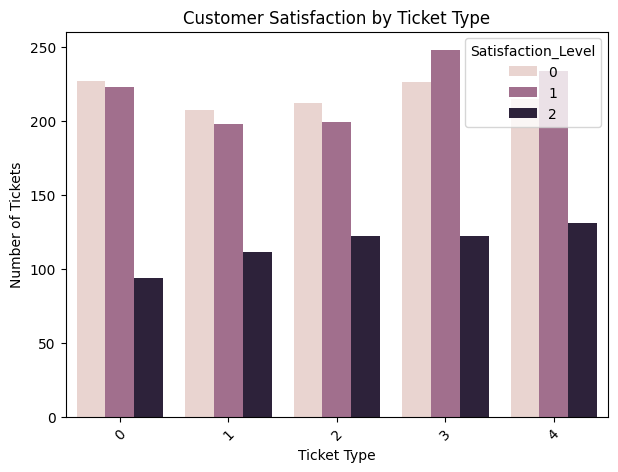

In [90]:
# Satisfaction Level by Ticket Type
plt.figure(figsize=(7,5))
sns.countplot(
    x='Ticket Type',
    hue='Satisfaction_Level',
    data=data
)
plt.title('Customer Satisfaction by Ticket Type')
plt.xlabel('Ticket Type')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45)
plt.show()



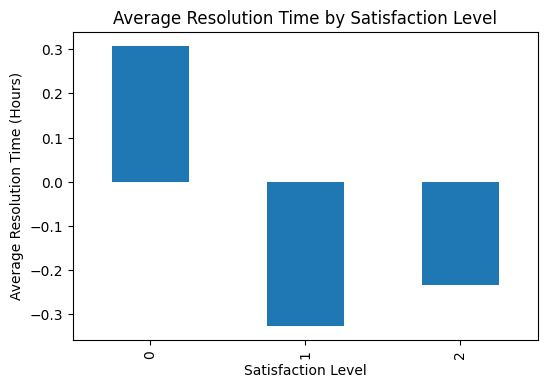

In [91]:
# Average Resolution Time vs Satisfaction Level
avg_resolution = data.groupby('Satisfaction_Level')['Resolution_Time_Hours'].mean()

plt.figure(figsize=(6,4))
avg_resolution.plot(kind='bar')
plt.title('Average Resolution Time by Satisfaction Level')
plt.xlabel('Satisfaction Level')
plt.ylabel('Average Resolution Time (Hours)')
plt.show()


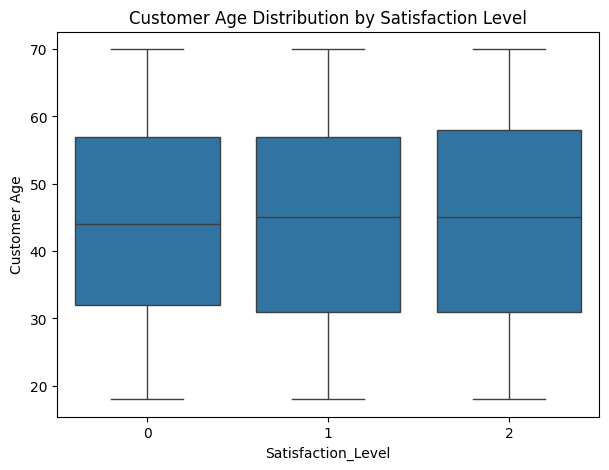

In [92]:
# Customer Age Distribution by Satisfaction Level
plt.figure(figsize=(7,5))
sns.boxplot(
    x='Satisfaction_Level',
    y='Customer Age',
    data=data
)
plt.title('Customer Age Distribution by Satisfaction Level')
plt.show()


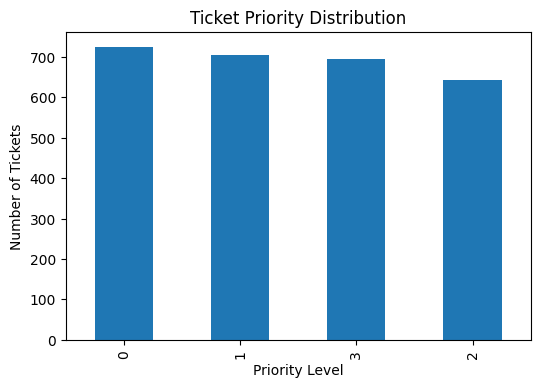

In [93]:
# Ticket Priority Distribution
plt.figure(figsize=(6,4))
data['Ticket Priority'].value_counts().plot(kind='bar')
plt.title('Ticket Priority Distribution')
plt.xlabel('Priority Level')
plt.ylabel('Number of Tickets')
plt.show()


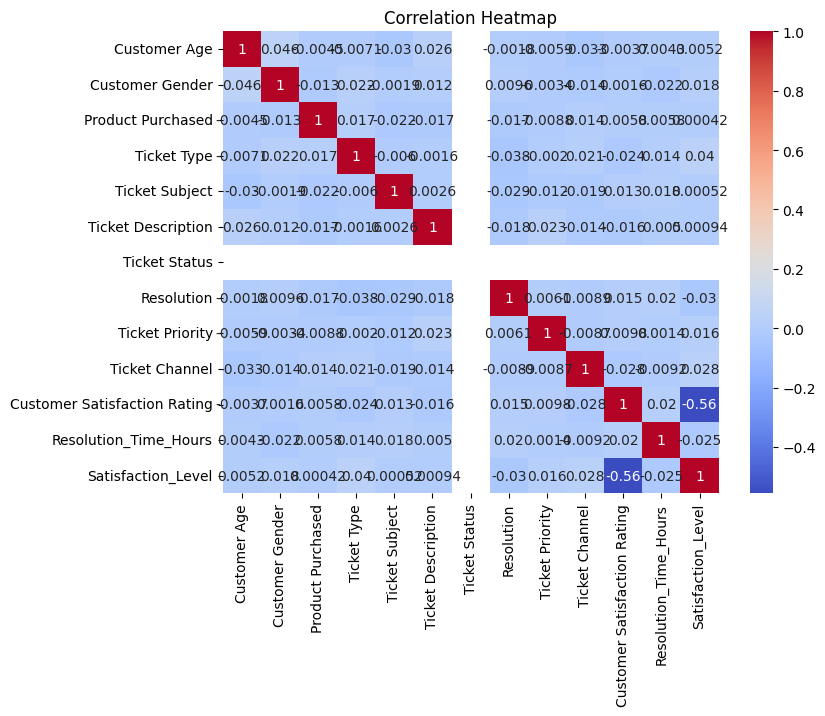

In [94]:
# Heatmap – Correlation of Numerical Features
plt.figure(figsize=(8,6))
sns.heatmap(
    data.select_dtypes(include=['int64','float64']).corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Heatmap')
plt.show()



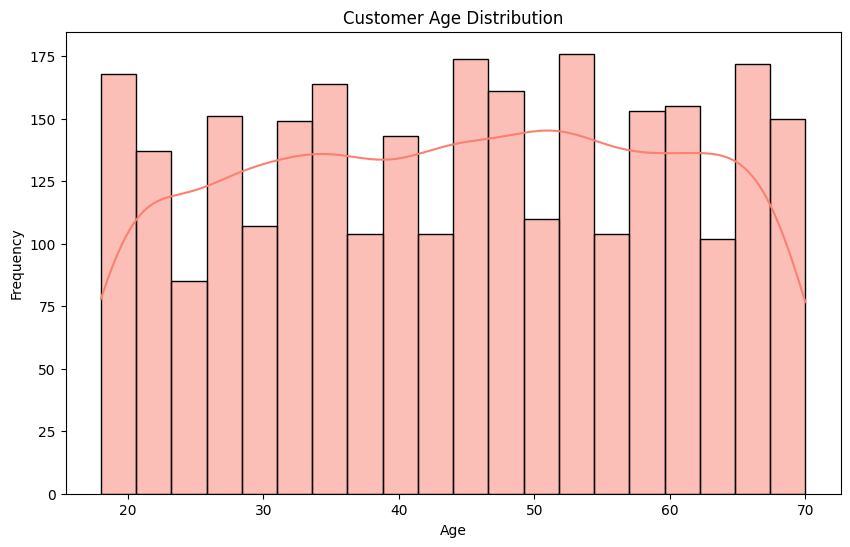

In [95]:
#Customer Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Customer Age'], bins=20, kde=True,
color='salmon')
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()